In [ ]:
import pandas as pd
from pathlib import Path
import numpy as np
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
import matplotlib.pyplot as plt
#export
import math, random
import torch
from IPython.display import Audio
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio
from torch.utils.data import random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
try:
# Import will succeed only if torchaudio has been installed
  import torchaudio
  from torchaudio import transforms
except ImportError as e:
  pass


In [ ]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1YRARDu0ra3UlXdagQu0R8TUotEni7Ep2/'
id = link.split("/")[-2]
print (id)
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('VoiceTone_Training_Set.csv')  
df_train = pd.read_csv('VoiceTone_Training_Set.csv')
df_train['FileName'] = df_train['FileName'].map(str)

1YRARDu0ra3UlXdagQu0R8TUotEni7Ep2


In [ ]:
class AudioUtil():
    # ----------------------------
    # Load an audio file. Return the signal as a tensor and the sample rate
    # ----------------------------
    @staticmethod
    def open(audio_file):
        sig, sr = torchaudio.load(audio_file)
        return (sig, sr)
    
    # ----------------------------
    # Show a widget to play the audio sound
    # ----------------------------
    @staticmethod
    def play(aud):
        sig,sr=aud
        display(Audio(data=sig, rate=sr))

    # ----------------------------
    # Shifts the signal to the left or right by some percent. Values at the end
    # are 'wrapped around' to the start of the transformed signal.
    # ----------------------------
    @staticmethod
    def time_shift(aud, shift_limit):
      sig,sr = aud
      _, sig_len = sig.shape
      shift_amt = int(random.random() * shift_limit * sig_len)
      return (sig.roll(shift_amt), sr)

    @staticmethod
    def resample(aud, newsr):
      sig, sr = aud

      if (sr == newsr):
        # Nothing to do
        return aud

      num_channels = sig.shape[0]
      # Resample first channel
      resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
      if (num_channels > 1):
        # Resample the second channel and merge both channels
        retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
        resig = torch.cat([resig, retwo])

      return ((resig, newsr))

    @staticmethod
    def rechannel(aud, new_channel):
      sig, sr = aud

      if (sig.shape[0] == new_channel):
        # Nothing to do
        return aud

      if (new_channel == 1):
        # Convert from stereo to mono by selecting only the first channel
        resig = sig[:1, :]
      else:
        # Convert from mono to stereo by duplicating the first channel
        resig = torch.cat([sig, sig])

      return ((resig, sr))
        
    # ----------------------------
    # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
    # ----------------------------
    @staticmethod
    def pad_trunc(aud, max_ms):
        sig, sr = aud
        num_rows, sig_len = sig.shape
        max_len = sr//1000 * max_ms

        if (sig_len > max_len):
          # Truncate the signal to the given length
            sig = sig[:,:max_len]

        elif (sig_len < max_len):
          # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len

            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))

            sig = torch.cat((pad_begin, sig, pad_end), 1)

        return (sig, sr)
    
    # ----------------------------
    # Generate a Spectrogram
    # ----------------------------
    @staticmethod
    def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
        sig,sr = aud
        top_db = 80

        # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
        spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

        # Convert to decibels
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return (spec)

    # ----------------------------
    # Plot the audio signal
    # ----------------------------
    def show_wave(aud, label='', ax=None):
      sig, sr = aud
      if (not ax):
        _,ax = plt.subplots(1, 1, figsize=(3, 3))
      ax.plot(sig[0])
      ax.set_title(label)
    
    # ----------------------------
    # Pad (or trim) the signal to a fixed length 'max_ms' in milliseconds
    # ----------------------------
    @staticmethod
    def pad_trim(aud, max_ms):
      sig, sr = aud
      num_rows, sig_len = sig.shape
      max_len = sr//1000 * max_ms

      if (sig_len > max_len):
      # Trim the signal to the given length
        sig = sig[:,:max_len]

      elif (sig_len < max_len):
            # Length of padding to add at the beginning and end of the signal
        pad_begin_len = random.randint(0, max_len - sig_len)
        pad_end_len = max_len - sig_len - pad_begin_len

        # Pad with 0s
        pad_begin = torch.zeros((num_rows, pad_begin_len))
        pad_end = torch.zeros((num_rows, pad_end_len))

        sig = torch.cat((pad_begin, sig, pad_end), 1)

      return (sig, sr)
    # ----------------------------
    # Plot the audio signal before and after a transform
    # ----------------------------
    def show_transform(orig, trans):
        osig,osr = orig
        tsig,tsr = trans
        if orig is not None: plt.plot(osig[0], 'm', label="Orig.")
        if trans is not None: plt.plot(tsig[0], 'c', alpha=0.5, label="Transf.")
        plt.legend()
        plt.show()

    @staticmethod
    def signal_shift(aud, max_shift_pct):
      sig,sr = aud
      roll_by = int(random.random()*max_shift_pct*len(sig[0]))
      return (sig.roll(roll_by), sr)

    # ----------------------------
    # Plot the spectrogram
    # ----------------------------
    def show_spectro(spec, label='', ax=None, figsize=(6,6)):
      if (not ax):
        _,ax = plt.subplots(1, 1, figsize=figsize)
    # Reduce first dimension if it is greyscale
      ax.imshow(spec if (spec.shape[0]==3) else spec.squeeze(0))
      ax.set_title(f'{label}, {list(spec.shape)}')


    @staticmethod
    def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
      _, n_mels, n_steps = spec.shape

    # Frequency Masking: frequency channels [f0, f0 + f) are masked. f is chosen from a 
    # uniform distribution from 0 to the frequency mask parameter F, and f0 is chosen 
    # from (0, ν − f) where ν is the number of frequency channels.
    # Time Masking: t consecutive time steps [t0, t0 + t) are masked. t is chosen from a 
    # uniform distribution from 0 to the time mask parameter T, and t0 is chosen from [0, τ − t).

      # Max height of the frequency mask
      F = math.ceil(n_mels * max_mask_pct) # rounding up in case of small %
      # Max width of the time mask
      T = math.ceil(n_steps * max_mask_pct)

      # Create frequency masks
      fill = spec.mean()
      for i in range(0, n_freq_masks):
        f = random.randint(0, F)
        f0 = random.randint(0, n_mels-f)
        spec[0][f0:f0+f] = fill

      # Create time masks
      for i in range(0, n_time_masks):
        t = random.randint(0, T)
        t0 = random.randint(0, n_steps-t)
        spec[0][:,t0:t0+t] = fill
      return spec

In [ ]:
root_dir = "/content/drive/MyDrive/Voice"
base_dir = root_dir + '/Train Files'

AUDIO_PATH = Path(base_dir) 
AUDIO_FILE = AUDIO_PATH/'11064.wav'

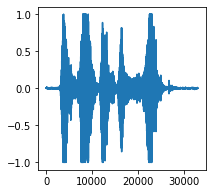

In [ ]:
test_file = AUDIO_FILE
test_aud = AudioUtil.open(test_file)
AudioUtil.play(test_aud)
AudioUtil.show_wave(test_aud)

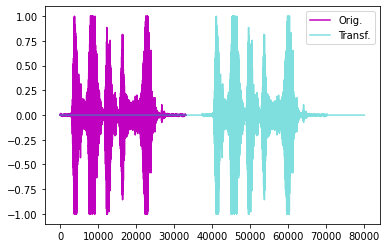

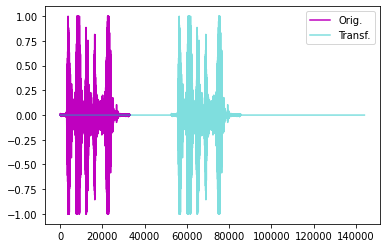

In [ ]:
test_aud_len = test_aud[0].shape[1] / test_aud[1]
f'Audio is {test_aud_len} seconds'

test_trim = AudioUtil.pad_trim(test_aud, max_ms=5000)
AudioUtil.show_transform(test_aud, test_trim)

test_pad = AudioUtil.pad_trim(test_aud, max_ms=9000)
AudioUtil.show_transform(test_aud, test_pad)

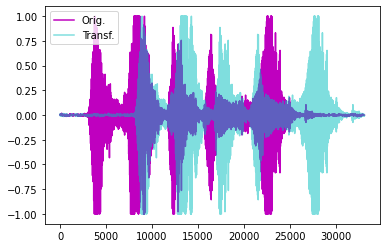

In [ ]:
test_shift = AudioUtil.signal_shift(test_aud, max_shift_pct=0.5)
AudioUtil.show_transform(test_aud, test_shift)

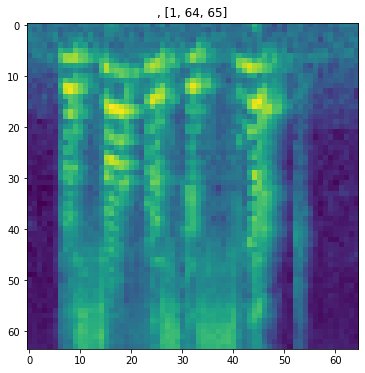

In [ ]:
test_spec = AudioUtil.spectro_gram(test_aud)
AudioUtil.show_spectro(test_spec)

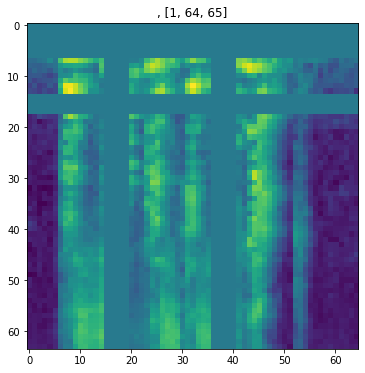

In [ ]:
test_aug = AudioUtil.spectro_augment(test_spec, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)
AudioUtil.show_spectro(test_aug)

In [ ]:
# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
    def __init__(self, df, data_path):
        self.df = df
        self.data_path = str(data_path)
        self.duration = 4000
        self.sr = 44100
        self.channel = 2
        self.shift_pct = 0.4
            
  # ----------------------------
  # Number of items in dataset
  # ----------------------------
    def __len__(self):
        return len(self.df)    
    
  # ----------------------------
  # Get i'th item in dataset
  # ----------------------------
    def __getitem__(self, idx):
        # Absolute file path of the audio file - concatenate the audio directory with
        # the relative path
        audio_file = self.data_path + self.df.loc[idx, 'FileName'] + ".wav"
        # Get the Class ID
        class_id = self.df.loc[idx, 'Res2']

        # Absolute file path of the audio file - concatenate the audio directory with
        # the relative path
        # audio_file = self.data_path + self.df.iloc[0].astype(str)
        # Get the Class ID
        # class_id = self.df.iloc[2]

        aud = AudioUtil.open(audio_file)
        # Some sounds have a higher sample rate, or fewer channels compared to the
        # majority. So make all sounds have the same number of channels and same 
        # sample rate. Unless the sample rate is the same, the pad_trunc will still
        # result in arrays of different lengths, even though the sound duration is
        # the same.
        reaud = AudioUtil.resample(aud, self.sr)
        rechan = AudioUtil.rechannel(reaud, self.channel)

        dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
        shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
        sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
        aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

        return aug_sgram, class_id

In [ ]:
myds = SoundDS(df_train, '/content/drive/MyDrive/Voice/Train Files/')
# Random split of 80:20 between training and validation
num_items = myds.__len__()
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=32, shuffle=False)

In [ ]:
# ----------------------------
# Audio Classification Model
# ----------------------------
class AudioClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Second Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Second Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=10)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

# Create the model and put it on the GPU if available
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cuda', index=0)

In [ ]:
from torch.utils import data
# ----------------------------
# Training Loop
# ----------------------------
def training(model, train_dl, num_epochs):
  # Loss Function, Optimizer and Scheduler
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                                steps_per_epoch=int(len(train_dl)),
                                                epochs=num_epochs,
                                                anneal_strategy='linear')

  # Repeat for each epoch
  for epoch in range(num_epochs):
    running_loss = 0.0
    correct_prediction = 0
    total_prediction = 0
# Repeat for each batch in the training set
    for i, data in enumerate(train_dl):

      # Get the input features and target labels, and put them on the GPU
      inputs = data[0].to(device)
      labels = data[1].type(torch.LongTensor)
      labels = labels.to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      scheduler.step()

      # Keep stats for Loss and Accuracy
      running_loss += loss.item()

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]

      # if i % 10 == 0:   #print every 10 mini-batches
      print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))

# Print stats at the end of the epoch
    num_batches = len(train_dl)
    avg_loss = running_loss / num_batches
    acc = correct_prediction/total_prediction
    print(f'Epoch: {epoch}, Loss: {avg_loss:.2f}, Accuracy: {acc*100:.0f}%')

  print('Finished Training')
  
num_epochs =  100  # Just for demo, adjust this higher.
training(myModel, train_dl, num_epochs)

Streaming output truncated to the last 5000 lines.
[70,    86] loss: 6.869
[70,    87] loss: 6.951
[70,    88] loss: 7.043
[70,    89] loss: 7.106
[70,    90] loss: 7.190
[70,    91] loss: 7.264
[70,    92] loss: 7.320
[70,    93] loss: 7.377
[70,    94] loss: 7.470
[70,    95] loss: 7.562
[70,    96] loss: 7.645
[70,    97] loss: 7.725
[70,    98] loss: 7.816
[70,    99] loss: 7.892
[70,   100] loss: 7.963
[70,   101] loss: 8.039
[70,   102] loss: 8.131
[70,   103] loss: 8.187
[70,   104] loss: 8.284
[70,   105] loss: 8.343
[70,   106] loss: 8.413
[70,   107] loss: 8.510
[70,   108] loss: 8.583
[70,   109] loss: 8.659
[70,   110] loss: 8.729
[70,   111] loss: 8.778
[70,   112] loss: 8.853
[70,   113] loss: 8.945
[70,   114] loss: 9.026
[70,   115] loss: 9.112
[70,   116] loss: 9.197
[70,   117] loss: 9.264
[70,   118] loss: 9.329
[70,   119] loss: 9.406
[70,   120] loss: 9.500
[70,   121] loss: 9.581
[70,   122] loss: 9.694
[70,   123] loss: 9.761
[70,   124] loss: 9.839
[70,   125] l

In [ ]:
# ----------------------------
# Inference
# ----------------------------
def inference (model, val_dl):
  correct_prediction = 0
  total_prediction = 0

  # Disable gradient updates
  with torch.no_grad():
    for data in val_dl:

      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]
    
  acc = correct_prediction/total_prediction
  print(f'Accuracy: {acc*100:.0f}%, Total items: {total_prediction}')

# Run inference on trained model with the validation set
inference(myModel, val_dl)

Accuracy: 62%, Total items: 1300


In [ ]:
link = 'https://drive.google.com/file/d/1CsnHiphfd3KjGk9VQoaRLZzCHwvT9lt7/'
id = link.split("/")[-2]
print (id)
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('VoiceTone_Test_Set.csv')
df_test = pd.read_csv('VoiceTone_Test_Set.csv')
df_test['FileName'] = df_test['FileName'].map(str)
test_ds = SoundDS(df_test, '/content/drive/MyDrive/Voice/Voice Tone Test Audio Files/')
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=32, shuffle=False)

1CsnHiphfd3KjGk9VQoaRLZzCHwvT9lt7


In [ ]:
import tensorflow as tf
# ----------------------------
# Inference
# ----------------------------
def inference (model, test_dl):
  correct_prediction = 0
  total_prediction = 0
  batch_label_list = []
  label_list = []

  # Disable gradient updates
  with torch.no_grad():
    for data in test_dl:

      # Get the input features and target labels, and put them on the GPU
      inputs, labels = data[0].to(device), data[1].to(device)

      # Normalize the inputs
      inputs_m, inputs_s = inputs.mean(), inputs.std()
      inputs = (inputs - inputs_m) / inputs_s

      # Get predictions
      outputs = model(inputs)

      # Get the predicted class with the highest score
      _, prediction = torch.max(outputs,1)
      batch_label_list.append(prediction.cpu().tolist())

      # Count of predictions that matched the target label
      correct_prediction += (prediction == labels).sum().item()
      total_prediction += prediction.shape[0]

    for i in batch_label_list:
      for j in i:
        label_list.append(j)
    print('List of Predicted Labels: ', label_list)
    
  acc = correct_prediction/total_prediction
  print(f'Total items: {total_prediction}')
  return label_list

# Run inference on trained model with the validation set
label_list = inference(myModel, test_dl)

List of Predicted Labels:  [5, 3, 0, 0, 0, 3, 3, 1, 1, 2, 0, 4, 5, 5, 2, 3, 3, 1, 2, 0, 0, 1, 2, 2, 0, 2, 2, 4, 1, 0, 4, 3, 1, 5, 0, 5, 2, 2, 2, 1, 0, 5, 1, 0, 1, 0, 5, 4, 5, 5, 3, 2, 3, 2, 2, 1, 3, 5, 0, 4, 4, 5, 0, 2, 4, 5, 3, 2, 4, 1, 0, 2, 3, 2, 3, 2, 3, 1, 1, 4, 0, 5, 3, 1, 2, 2, 3, 5, 4, 2, 1, 2, 5, 5, 1, 0, 3, 2, 5, 4, 4, 0, 4, 0, 2, 4, 0, 0, 5, 2, 5, 5, 4, 0, 0, 1, 3, 4, 2, 2, 5, 0, 2, 4, 4, 3, 1, 2, 2, 3, 0, 3, 3, 2, 3, 4, 0, 0, 4, 4, 1, 2, 5, 5, 5, 1, 0, 2, 3, 0, 5, 3, 0, 4, 1, 3, 3, 0, 2, 5, 0, 1, 2, 3, 5, 4, 4, 1, 3, 1, 2, 4, 1, 0, 2, 5, 0, 3, 5, 2, 2, 5, 2, 5, 4, 0, 3, 2, 1, 1, 4, 3, 2, 2, 2, 3, 0, 3, 1, 0, 1, 5, 1, 1, 5, 0, 4, 0, 4, 0, 1, 0, 5, 4, 3, 4, 5, 5, 5, 2, 3, 5, 1, 0, 1, 2, 2, 3, 4, 2, 5, 3, 2, 4, 3, 5, 5, 2, 1, 3, 0, 0, 3, 1, 2, 4, 5, 4, 2, 3, 1, 0, 0, 5, 3, 0, 2, 5, 0, 0, 1, 3, 3, 5, 5, 2, 3, 3, 4, 4, 1, 2, 1, 0, 5, 5, 1, 5, 0, 1, 2, 2, 0, 5, 3, 2, 2, 0, 2, 4, 5, 1, 1, 3, 1, 0, 2, 1, 4, 0, 5, 2, 2, 1, 4, 5, 3, 4, 2, 1, 1, 5, 5, 3, 2, 4, 0, 2, 0, 1, 1, 4, 3, 3, 

In [ ]:
df_test['pred_Res2'] = label_list
df_test.to_csv('VoiceTone_Test_Set.csv')